In [2]:
from google.colab import files
uploaded = files.upload()


Saving feedback_data.csv to feedback_data.csv


root
 |-- Customer ID: string (nullable = true)
 |-- Feedback Channel: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Comment: string (nullable = true)
 |-- Date: date (nullable = true)

+--------------------+-----+
|    Customer Segment|count|
+--------------------+-----+
|     Loyal Customers|   15|
|   Neutral Customers|   79|
|Dissatisfied Cust...|    6|
+--------------------+-----+



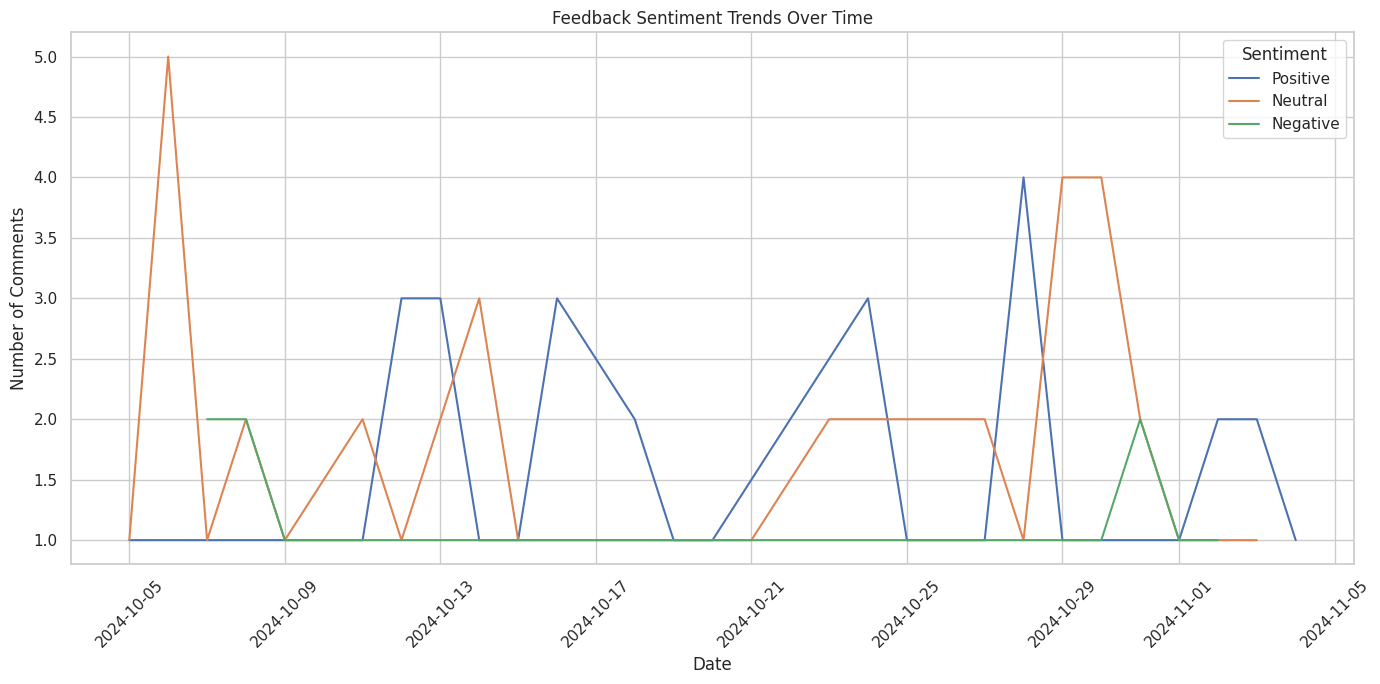

<Figure size 640x480 with 0 Axes>

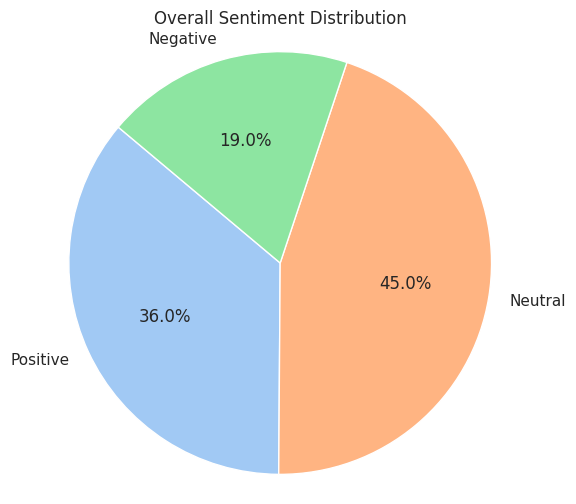

<Figure size 640x480 with 0 Axes>

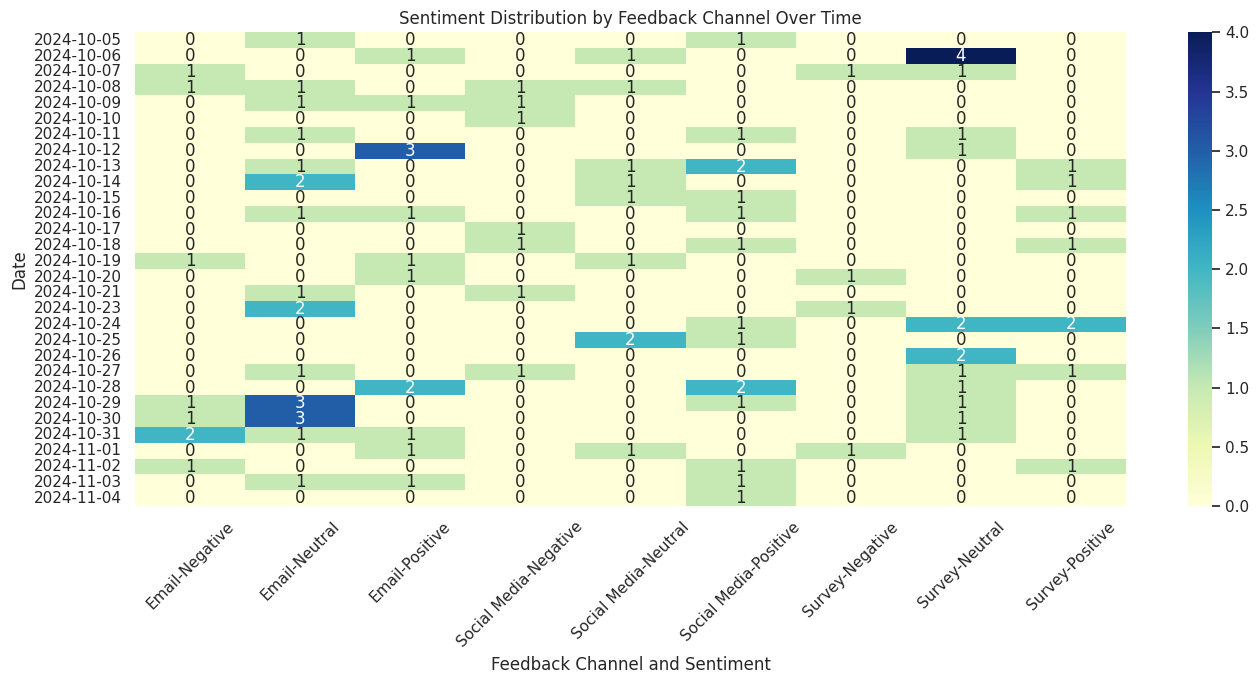

<ipython-input-28-6a7de98fbc78>:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Feedback Channel", y="Rating", data=feedback_pandas, palette="Set3")


<Figure size 640x480 with 0 Axes>

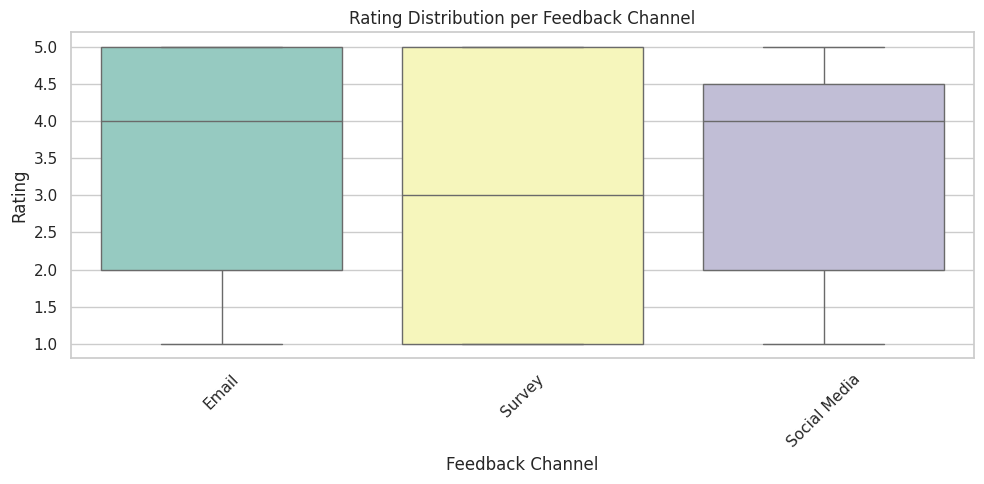

<ipython-input-28-6a7de98fbc78>:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Feedback Channel", y="Average Rating", data=channel_avg_rating_df.toPandas(), palette="viridis")


<Figure size 640x480 with 0 Axes>

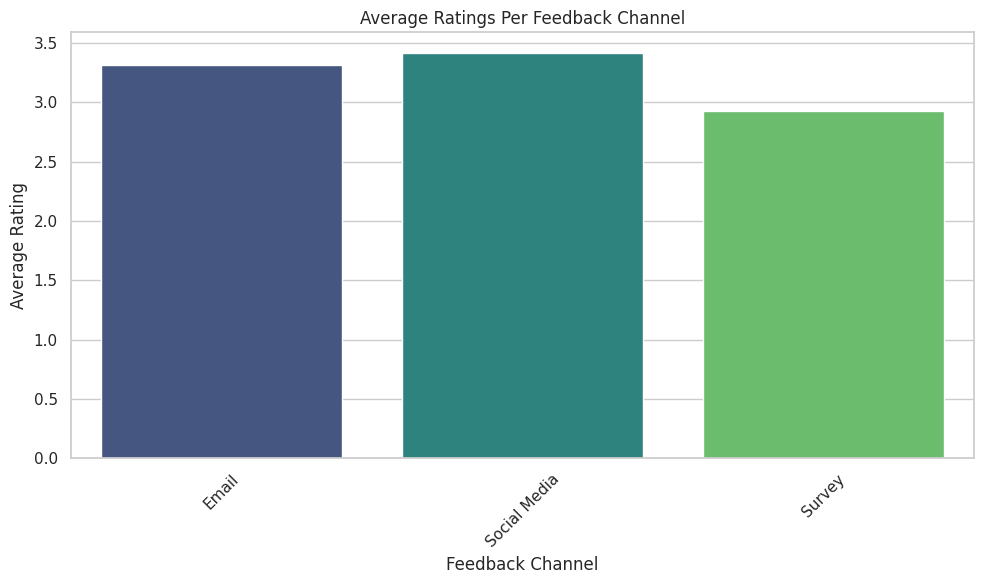

<Figure size 640x480 with 0 Axes>

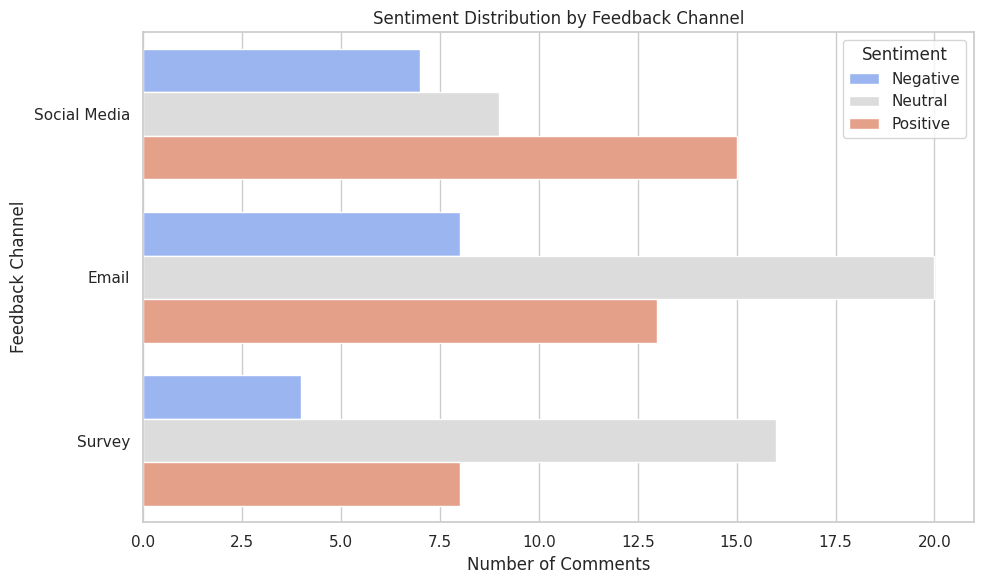

<Figure size 640x480 with 0 Axes>

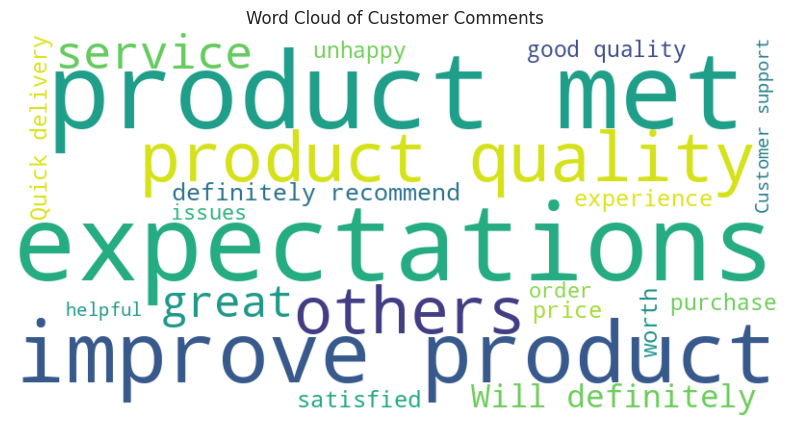

<Figure size 640x480 with 0 Axes>

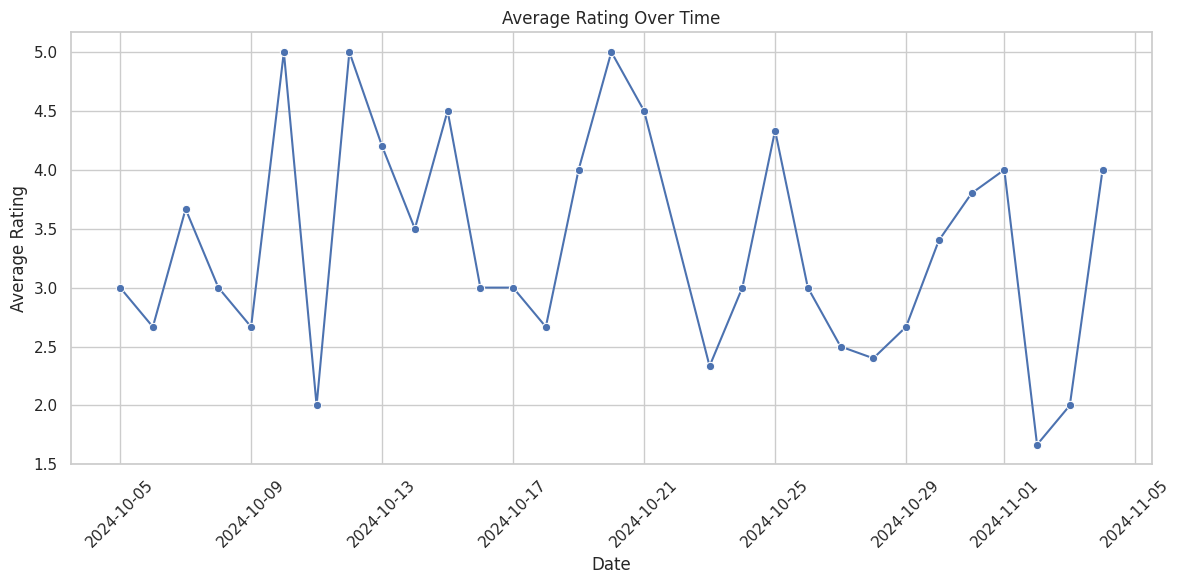

<Figure size 640x480 with 0 Axes>

In [28]:
from pyspark.sql import SparkSession
import pandas as pd

spark = SparkSession.builder \
    .appName("Customer Feedback Analysis") \
    .getOrCreate()

feedback_df = spark.read.csv("feedback_data.csv", header=True, inferSchema=True)

feedback_df.printSchema()

from pyspark.sql.functions import col, lower, regexp_replace

feedback_df = feedback_df.withColumn("Cleaned_Comment", lower(col("Comment")))
feedback_df = feedback_df.withColumn("Cleaned_Comment", regexp_replace(col("Cleaned_Comment"), "[^a-zA-Z0-9 ]", ""))

feedback_df = feedback_df.fillna({"Comment": "No comment provided", "Rating": 3})
feedback_df = feedback_df.fillna({"Cleaned_Comment": ""})

from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def get_sentiment(text):
    if text is None or text == "":
        return "Neutral"
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity == 0:
        return "Neutral"
    else:
        return "Negative"

sentiment_udf = udf(get_sentiment, StringType())

feedback_df = feedback_df.withColumn("Sentiment", sentiment_udf(col("Cleaned_Comment")))

from pyspark.sql.functions import when

feedback_df = feedback_df.withColumn("Customer Segment",
    when((col("Rating") >= 4) & (col("Sentiment") == "Positive"), "Loyal Customers")
    .when((col("Rating") <= 2) & (col("Sentiment") == "Negative"), "Dissatisfied Customers")
    .otherwise("Neutral Customers")
)

customer_segment_counts = feedback_df.groupBy("Customer Segment").count()
customer_segment_counts.show()

feedback_df.write.csv("processed_feedback_output19.csv", header=True)

from pyspark.sql.functions import count, avg, to_date

feedback_df = feedback_df.withColumn("Date", to_date(col("Date"), "dd-MM-yyyy"))

trend_df = feedback_df.groupBy("Date", "Sentiment").agg(count("Sentiment").alias("Sentiment Count"))

channel_sentiment_df = feedback_df.groupBy("Feedback Channel", "Sentiment").agg(count("Sentiment").alias("Sentiment Count"))

channel_avg_rating_df = feedback_df.groupBy("Feedback Channel").agg(avg("Rating").alias("Average Rating"))

trend_pandas = trend_df.toPandas()
channel_sentiment_pandas = channel_sentiment_df.toPandas()
channel_avg_rating_pandas = channel_avg_rating_df.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set(style="whitegrid")

plt.figure(figsize=(14, 7))
sns.lineplot(x="Date", y="Sentiment Count", hue="Sentiment", data=trend_pandas)
plt.title("Feedback Sentiment Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

plt.subplots_adjust(hspace=0.5)

plt.figure(figsize=(6, 6))
sentiment_counts = feedback_df.groupBy("Sentiment").agg(count("Sentiment").alias("Count")).toPandas()
plt.pie(sentiment_counts['Count'], labels=sentiment_counts['Sentiment'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Overall Sentiment Distribution")
plt.axis('equal')

plt.show()

plt.subplots_adjust(hspace=0.5)

heatmap_data = feedback_df.groupBy("Date", "Feedback Channel", "Sentiment") \
    .agg(count("Sentiment").alias("Sentiment Count")) \
    .toPandas()
heatmap_pivot = heatmap_data.pivot_table(index="Date", columns=["Feedback Channel", "Sentiment"], values="Sentiment Count", fill_value=0)
heatmap_pivot = heatmap_pivot.fillna(0)
heatmap_pivot = heatmap_pivot.astype(int)

plt.figure(figsize=(14, 7))
sns.heatmap(heatmap_pivot, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Sentiment Distribution by Feedback Channel Over Time")
plt.xlabel("Feedback Channel and Sentiment")
plt.ylabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

plt.subplots_adjust(hspace=0.5)

feedback_pandas = feedback_df.toPandas()

plt.figure(figsize=(10, 5))
sns.boxplot(x="Feedback Channel", y="Rating", data=feedback_pandas, palette="Set3")
plt.title("Rating Distribution per Feedback Channel")
plt.xlabel("Feedback Channel")
plt.ylabel("Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.subplots_adjust(hspace=0.5)

plt.figure(figsize=(10, 6))
sns.barplot(x="Feedback Channel", y="Average Rating", data=channel_avg_rating_df.toPandas(), palette="viridis")
plt.title("Average Ratings Per Feedback Channel")
plt.xlabel("Feedback Channel")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.subplots_adjust(hspace=0.5)

channel_sentiment_counts = feedback_df.groupBy("Feedback Channel", "Sentiment").agg(count("Sentiment").alias("Comment Count"))

channel_sentiment_counts_pd = channel_sentiment_counts.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="Comment Count", y="Feedback Channel", hue="Sentiment", data=channel_sentiment_counts_pd, palette="coolwarm")
plt.title("Sentiment Distribution by Feedback Channel")
plt.xlabel("Number of Comments")
plt.ylabel("Feedback Channel")
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

plt.subplots_adjust(hspace=0.5)

comments_text = ' '.join(feedback_df.select("Comment").rdd.flatMap(lambda x: x).collect())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Customer Comments")
plt.show()

plt.subplots_adjust(hspace=0.5)

average_rating_df = feedback_df.groupBy("Date").agg(avg("Rating").alias("Average Rating")).orderBy("Date")

average_rating_pandas = average_rating_df.toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Average Rating', data=average_rating_pandas, marker='o')
plt.title("Average Rating Over Time")
plt.xlabel("Date")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.subplots_adjust(hspace=0.5)
spark.stop()
